# CS-345 Coursework Implementation
Kristofer Ralph (909183)


In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import skimage.feature 
import tensorflow as tf
import tensorflow.keras as keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
import time
import itertools

In [5]:
def compute_features(image):
    """ Provided code.
        Uses histogram of gradients on an image to perform feature extraction. """
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return (hog_feature, hog_as_image)

def compute_all_features(images):
    """ Loop over a list of images and produce a list of computed features.
        Incredibly resource heavy, takes about 30s on my computer. """
    hog_features, hog_images  = [], []
    for i in range(images.shape[-1]):
        hog_feat, hog_img = compute_features(images[:,:,:,i])
        hog_features.append(hog_feat)
        hog_images.append(hog_img)
    return hog_features, hog_images

trnImage = np.load("trnImage.npy")
trnLabel = np.load("trnLabel.npy")
testImage = np.load("tstImage.npy")
testLabel = np.load("tstLabel.npy")

# compute hogs for images
start = time.clock()
trn_hog_feature, trn_hog_image = compute_all_features(trnImage)
test_hog_feature, test_hog_image = compute_all_features(testImage)
t = time.clock() - start

print(str(t) + " seconds elapsed")

class_names = {
    1: "Airplane",
    2: "Automobile",
    3: "Bird",
    4: "Cat",
    5: "Deer",
    6: "Dog",
    7: "Frog",
    8: "Horse",
    9: "Ship",
    10: "Truck"
}

40.240768 seconds elapsed


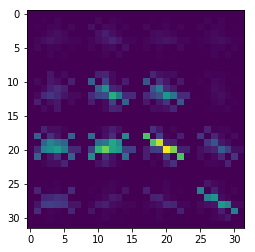

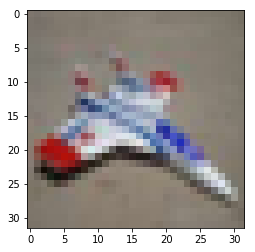

In [3]:
plt.figure()
plt.imshow(trn_hog_image[1])
plt.figure()
plt.imshow(trnImage[:,:,:,1])

In [7]:
# Models

# Basic model, no preprocessing applied.
# Utilizes some topology advice from https://arxiv.org/pdf/1511.02580.pdf
# and implements bottlenecking layers.
def base_model(num_classes=11):
    # Build a really basic multilayer perceptron model.
    model = Sequential()
    model.add(Dense(1024, input_shape=(32*32*3,)))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    return model

# HoG model, to be used with data preprocessed with histograms of gradients to extract features.
def hog_model(num_classes=11):
    model = Sequential()
    model.add(Dense(324, input_shape=(324,)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    return model

# PCA model, to be used with data preprocessed with PCA.
def PCA_model():
    model = Sequential()
    return model

# LDA model, to be used with data preprocessed with linear discriminant analysis
def LDA_model():
    model = Sequential()
    return model   

# Something here


In [13]:
# Change this to change the type of NN model used. 
# Options are either base_model or hog_model.
build_model = hog_model

# check if we need to use the hogged dataset.
if build_model == base_model:
    (x_train, y_train), (x_test, y_test) = (trnImage.T, trnLabel), (testImage.T, testLabel)
    # normalize x-values between 0 and 1
    x_train /= 255
    x_test /= 255
else:
    (x_train, y_train), (x_test, y_test) = (trn_hog_feature, trnLabel), (test_hog_feature, testLabel)
        
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
    
# use these flattening reshape ops with multilayer perceptron
x_train = np.reshape(x_train, (-1, np.product(x_train[0].shape)))
x_test = np.reshape(x_test, (-1, np.product(x_test[0].shape)))


# optimizer
adam = Adam(1e-4)
    
# modile compiling & fitting
model = build_model()

model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
loss, acc = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
    
print("Accuracy: {0:.2f}%".format(acc*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 324)               105300    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               41600     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 11)                1419      
Total params: 181,343
Trainable params: 181,343
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 3s 263us/step - loss: 2.

Confusion matrix, without normalization
[[72  1  5  1  4  2  3  6  3  3]
 [ 4 49  0  2  7  1  5  3 17 12]
 [12  2 35  8  9 14 12  5  2  1]
 [ 2  2 12 39 13 10  9 10  1  2]
 [ 2  1  5  8 63  6  5  6  2  2]
 [ 1  1  4 15 10 49  8 11  0  1]
 [ 2  3  3  8 12  4 64  4  0  0]
 [ 0  0  3  8 10  5  2 68  1  3]
 [20  8  3  2  4  0  1  1 54  7]
 [ 4  7  2  2  5  2  0  5  9 64]]


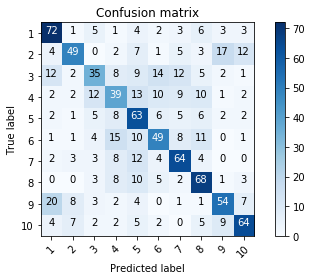

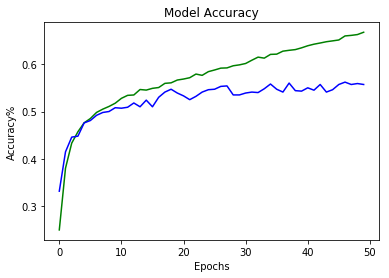

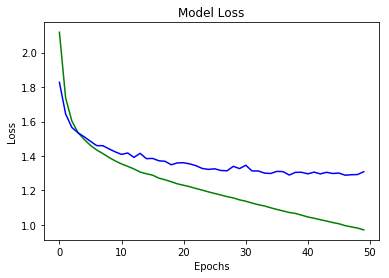

In [14]:
# Graphs and Plots

# confusion_matrix plotting code sourced from
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
# print the confusion matrix from the history object

confusion = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig = plt.figure()
plot_confusion_matrix(confusion, classes=class_names)

# plot the loss function and the accuracy over time
plt.figure()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy%")
plt.plot(hist.history['acc'], c="green")
plt.plot(hist.history['val_acc'], c="blue")
plt.figure()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(hist.history['loss'], c="green")
plt.plot(hist.history['val_loss'], c="blue")
plt.show()

In [2]:
print(tf.test.is_gpu_available())
# Question: How does the depth of a neural network affect accuracy and training time?
# George is taking that.
# New question: How does the preprocessing applied to data affect neural network accuracy and training time?

True
